# Projeto

Neste projeto, vamos usar classificadores para identificar *quais são os fatores de risco para o acidente vascular cerebral (AVC)*. Um AVC (*stroke*) é um dano cerebral causado pela interrupção de seu fluxo sanguíneo. Ter um AVC é um problema sério porque pode levar a sequelas, então é melhor preveni-lo do que tentar lidar com suas consequências.

Temos à nossa disposição um conjunto de dados para [predição de AVCs](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). O que faremos é:

1. Treinar um classificador para predizer se houve ou não houve AVCs
1. Verificar a acurácia do classificador
1. Identificar quais são os fatores que mais provavelmente estão ligados a ter AVCs

## Teoria

### Separando linhas de dados em treino e teste

O que faremos será avaliar um classificador. Lembre-se que para fazer o classificador tivemos que usar uma base de dados pré-classificada. Porém, o que gostaríamos de saber é se, ao ser colocado em produção, o classificador terá um bom desempenho.

Para isso, vamos partir de uma premissa (vou chamar de *premissa número 1* mas esse não é um nome oficial) que é muito importante: a de que nossa base de dados é composta de elementos amostrados aleatoriamente do conjunto total de dados. Nessas condições, a distribuição dos dados na nossa base de dados é a mesma distribuição dos dados que encontraremos no mundo real.

Claro que gostaríamos de saber como nosso classificador se comporta no mundo real, e não na amostra dele que compõe nossa base de dados! Então, precisamos ao menos de ter alguns dados que seguem a mesma distribuição dos dados do mundo real, e que serão usados nas mesmas condições que os dados do mundo real.

Por isso, dividimos nosso conjunto de dados em dois conjuntos: treino e teste. O conjunto de treino é o que será usado para treinar (`fit`) os nossos classificadores. O conjunto de teste será usado para testar (`score`) os classificadores. O conjunto de teste existe para simular uma situação de produção (como se o classificador estivesse operando), então ele não pode ser usado em hipótese alguma para nenhum tipo de ajuste de parâmetros. Ao mesmo tempo, o conjunto de treino é aquele que foi usado para "ensinar" rótulos corretos aos classificadores, então o desempenho dos classificadores no conjunto de treino não é representativo de seu desempenho em produção.

Para dividir os conjuntos de treino e teste, você pode usar a função `train_test_split` do scikit-learn:

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

### Analisando os dados

Antes de começar qualquer coisa, vamos (como sempre) olhar para os dados que temos. Na nossa tabela, temos uma coluna com a identificação do paciente - essa é uma ID única, anônima, que permite referenciar ao paciente. Também, temos várias colunas com características do paciente: idade, sexo, se fuma, etc. Por fim, temos uma coluna com o *outcome*, que é a coluna `stroke`. Para usar corretamente os classificadores do scikit-learn, você deve separar suas tabelas entre as que têm dados de "entrada" (as features) das que têm dados de "saída" (os *outcomes*).

Outra coisa importante é que os dados deste dataset podem ser categóricos, e nossos sistemas não lidam bem com eles. Por isso, precisamos convertê-los para dados numéricos, por exemplo usando one-hot encoding. Pandas implementa a conversão para one-hot encoding usando `pd.get_dummies(df)`.

# Manipulando o dataset

Explicação célula 0:

Importância: Ler o arquivo csv, que conta com o dataset, e remover linhas com dados faltantes .

Resultado:  Módulo necessários para manipular dados importados, e dataset convertidos em dataframe sem dados nulos.

--> célula 0

In [82]:
import pandas as pd
df = pd.read_csv('data.csv')
df = df.dropna()
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Explicação célula 1 :

Mesmo removendo os valores nulos, ainda existia um problema que impedia o andamento do projeto: existiam no dataset valores categóricos, sendo algo que dificulta a leitura e manipulação dos dados. Desta forma, utilizamos a função **get_dummies()** da biblioteca Pandas para transformar os valores categóricos em valores numéricos, utilizando **one-hot encoding**, ou seja, cada valor categórico é transformado em uma coluna, e cada linha desta coluna possui o valor 1 ou 0, indicando se o valor categórico está presente ou não naquela linha.

Além disso, devido ao fato de transformamos os nossos dados categóricos em representações, variando de 0 a 1, colunas com um range maior de variação e/ou irrelevantes para a classificação de avc (como id) ... iriam afetar nossa classificação, podendo servir como bias para o modelo preditor. Por isso, foi utilizado a função **drop()** da biblioteca Pandas para remover estas colunas.

Resultado:

Desta maneira, após as transformações descritas acima teremos um dataset com mais colunas, já que cada valor categórico foi transformado em uma coluna, sendo que cada uma delas possui apenas valores numéricos (0 ou 1).

--> célula 1

In [83]:
df_clean = pd.get_dummies(df).astype(float)
df_clean = df_clean.drop(columns=['id','age','avg_glucose_level', 'bmi'])
df_clean

,hypertension,heart_disease,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
5106,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Linear Classification Model

--> célula 0

In [84]:
import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad

Explicação célula 1:

Importância: Função para calcular o erro quadrático médio, da predição do valor target para o real valor do target.

Parametros:

--> W: Vetor de pesos, pesos que será dado a cada um das features.
$$
W = \begin{bmatrix}
w_0 & w_1 & ... & w_{N-1}\\
\end{bmatrix}
\hspace{0.5in}
$$


--> features: Features do dataset, dados selecionados que irão ser utilizados para preditar o target.

$$
features = \begin{bmatrix}
x_0 \\ x_1 \\ ... \\ x_{N-1}
\end{bmatrix}
\hspace{0.5in}
$$

--> B: Bias, que será utilizado para calcular o valor predito do target.

--> real_value: Real valor do target, dada as features.

Predição do valor target:


Transpondo W para realizar a multiplicação de matrizes com features e somando o bias cheganmos ao valore predito do target:

$$
\hat{y} = \sum_{i=0}^{N-1} w_i x_i + b
$$

Erro quadrático médio:

$$
MSE = \frac{1}{N} \sum_{i=0}^{N-1} (\hat{y_i} - y_i)^2
$$

Resultado: Função para calcular o erro quadrático médio, da predição do valor target para o real valor do target.



--> célula 1

In [85]:
def loss( parametros ):
    
    w, b, features, real_value = parametros
    
    prediction = w.T @ features + b

    mse = np_.mean( (prediction - real_value)**2)
    
    return mse

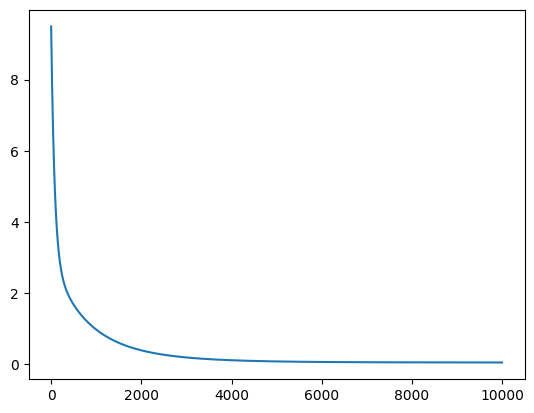

[('work_type_Govt_job', array([0.96225967])), ('work_type_Self-employed', array([0.931357])), ('work_type_Private', array([0.92404098])), ('gender_Other', array([0.89703018])), ('work_type_children', array([0.86337269])), ('ever_married_Yes', array([0.39938005])), ('Residence_type_Urban', array([0.35787052])), ('Residence_type_Rural', array([0.3556176])), ('work_type_Never_worked', array([0.33179032])), ('ever_married_No', array([0.30070937])), ('smoking_status_smokes', array([0.10093693])), ('heart_disease', array([0.10017186])), ('smoking_status_never smoked', array([0.07450308])), ('smoking_status_Unknown', array([0.07233052])), ('gender_Female', array([0.05550629])), ('gender_Male', array([0.05211868])), ('smoking_status_formerly smoked', array([0.04148511])), ('hypertension', array([0.03902945]))]


In [86]:


g = grad(loss)

X = df_clean.drop(columns=["stroke"])
data = df_clean.drop(columns=["stroke"]).to_numpy().astype(float)

target = df_clean["stroke"].to_numpy().astype(float)

w = np.random.randn(data.shape[1],1)
b = 0.0
alpha = 10**-3
erros = []

for n in range(10000):
    grad_ = g( (w, b, data.T, target) )
    
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]
    
    erros.append(loss( (w, b, data.T, target) ))

import matplotlib.pyplot as plt
plt.plot(erros)
plt.show()
    


importance = []
for i in range(len(w)):
   importance.append((X.columns[i],abs(w[i])))

# dilspay the importance of each feature, descending order using lambda
importance.sort(key=lambda x: x[1], reverse=True)
print(importance)


# Modelo de classificação DecisionTreeClassifier

X são as feautures, que serão usadas para prever Y, que é o outcome ou target. 

Nesse caso, o target é a coluna stroke, que indica se o paciente teve ou não um AVC.
E as features são as outras colunas, que indicam as características do paciente.

Explicação célula 0:

Importância: 

from sklearn.tree import DecisionTreeClassifier: importa o modelo DecisionTreeClassifier, que é um modelo de classificação que será utilizado.

from sklearn.model_selection import train_test_split: importa a função train_test_split, que será utilizada para separar os dados em treino e teste.

Resultado:  Módulos necessários para o projeto importados .

--> célula 0

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


Explicação célula 1:

Importância: Gerar as features. Para isso iremos remover a coluna stroke do nosso dataset, df_clean pois ela é o target, e não uma feature.

Resultado: DataFrame com as features

--> célula 1

In [88]:
# dataset 
# data, all columns except stroke
X = df_clean.drop(columns=["stroke"])
X

,hypertension,heart_disease,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
5106,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [89]:



# target, only stroke column
Y = df_clean["stroke"]

# split dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


clf = DecisionTreeClassifier()

clf.fit(X_train, Y_train)

print(f"Accuracy: {clf.score(X_test, Y_test)}")

importance = []
for i in range(len(clf.feature_importances_)):
   importance.append((X.columns[i],clf.feature_importances_[i]))

# dilspay the importance of each feature, descending order using lambda
importance.sort(key=lambda x: x[1], reverse=True)
print(importance)



Accuracy: 0.939918533604888
[('hypertension', 0.14265228689188678), ('heart_disease', 0.12430984567145434), ('gender_Female', 0.09613945108474153), ('gender_Male', 0.09435929589151157), ('Residence_type_Urban', 0.0731849262248986), ('Residence_type_Rural', 0.06710340907094334), ('work_type_Private', 0.06099959335929454), ('work_type_Self-employed', 0.060202437603332826), ('work_type_Govt_job', 0.06016626440007012), ('smoking_status_never smoked', 0.05522288054879616), ('smoking_status_formerly smoked', 0.04444516964734148), ('ever_married_No', 0.03375904643402733), ('smoking_status_smokes', 0.03207234256572771), ('ever_married_Yes', 0.027805647945934427), ('smoking_status_Unknown', 0.026766627774832193), ('work_type_children', 0.0006565808380304663), ('work_type_Never_worked', 0.00015419404717665356), ('gender_Other', 0.0)]
